# Block image Classification 

## Model Training

In [4]:
import numpy as np

import keras
from keras import layers

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='Pokemon/train',
  labels='inferred',
  label_mode='int',
  batch_size=12,
  image_size=(150, 150))

validation_ds = tf.keras.utils.image_dataset_from_directory(
  directory='Pokemon/val',
  labels='inferred',
  label_mode='int',
  batch_size=12,
  image_size=(150, 150))




Found 432 files belonging to 3 classes.
Found 432 files belonging to 3 classes.


In [6]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [7]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of training batches: 36
Number of validation batches: 29
Number of test batches: 7


2024-05-20 15:29:49.984012: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:29:50.457435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


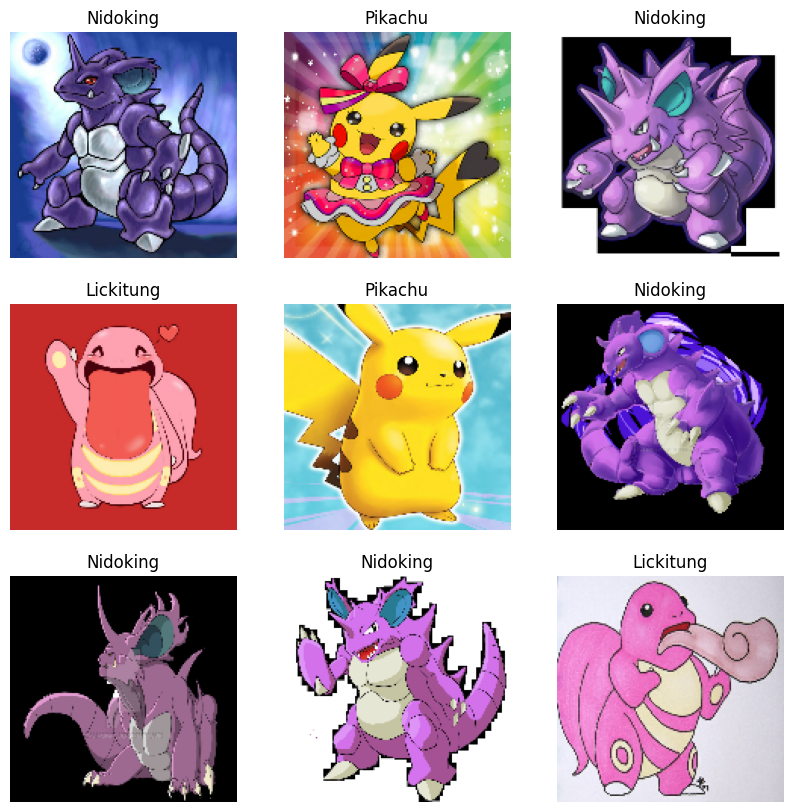

In [8]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
number_of_classes = len(train_ds.class_names)

In [10]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

## Using random data augmentation

In [11]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

2024-05-20 15:29:51.654188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:29:51.654651: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-20 15:29:51.692902: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:29:51.728116: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:29:51.750793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:29:52.002559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


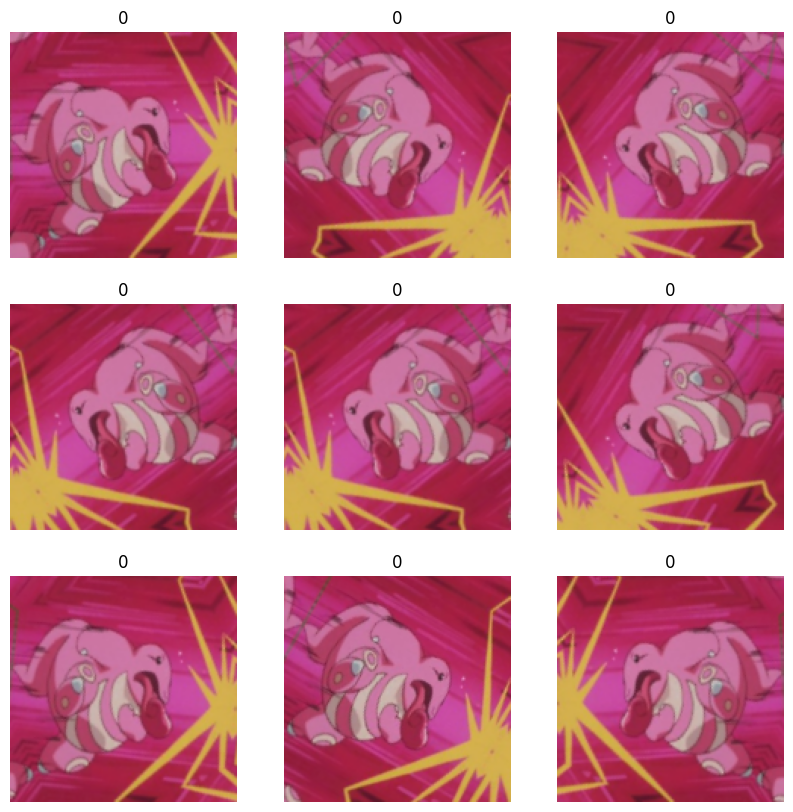

In [12]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

# Data Augmentation

In [13]:
base_model = keras.applications.Xception(
    weights="imagenet",  
    input_shape=(150, 150, 3),
    include_top=False,
)  

base_model.trainable = False
inputs = keras.Input(shape=(150, 150, 3))

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) 
outputs = keras.layers.Dense(number_of_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 3)             │      6,147 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [14]:
model.compile(optimizer=keras.optimizers.Adam(),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'])

initial_epochs = 4
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/4


2024-05-20 15:30:00.906698: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:01.032242: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:01.180104: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:01.764013: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/36 ━━━━━━━━━━━━━━━━━━━━ 3:22 6s/step - accuracy: 0.3333 - loss: 1.2123

2024-05-20 15:30:02.585037: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/36 ━━━━━━━━━━━━━━━━━━━━ 26s 773ms/step - accuracy: 0.3750 - loss: 1.1220

2024-05-20 15:30:03.384868: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/36 ━━━━━━━━━━━━━━━━━━━━ 21s 730ms/step - accuracy: 0.4292 - loss: 1.1444

2024-05-20 15:30:06.188019: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/36 ━━━━━━━━━━━━━━━━━━━━ 21s 747ms/step - accuracy: 0.4342 - loss: 1.1455

2024-05-20 15:30:07.084206: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:07.084264: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: cHRM: inconsistent chromaticities


 8/36 ━━━━━━━━━━━━━━━━━━━━ 20s 740ms/step - accuracy: 0.4398 - loss: 1.1433

2024-05-20 15:30:08.227295: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 52209564 exceeds 10% of free system memory.


 9/36 ━━━━━━━━━━━━━━━━━━━━ 20s 749ms/step - accuracy: 0.4444 - loss: 1.1393

2024-05-20 15:30:08.549893: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/36 ━━━━━━━━━━━━━━━━━━━━ 17s 738ms/step - accuracy: 0.4643 - loss: 1.1180

2024-05-20 15:30:10.673789: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/36 ━━━━━━━━━━━━━━━━━━━━ 13s 726ms/step - accuracy: 0.4969 - loss: 1.0774

2024-05-20 15:30:14.208323: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48765000 exceeds 10% of free system memory.


19/36 ━━━━━━━━━━━━━━━━━━━━ 12s 725ms/step - accuracy: 0.5065 - loss: 1.0635

2024-05-20 15:30:15.984109: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 45000000 exceeds 10% of free system memory.


20/36 ━━━━━━━━━━━━━━━━━━━━ 11s 728ms/step - accuracy: 0.5114 - loss: 1.0563

2024-05-20 15:30:16.397623: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/36 ━━━━━━━━━━━━━━━━━━━━ 10s 725ms/step - accuracy: 0.5163 - loss: 1.0493

2024-05-20 15:30:17.071962: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/36 ━━━━━━━━━━━━━━━━━━━━ 9s 725ms/step - accuracy: 0.5258 - loss: 1.0350 

2024-05-20 15:30:18.566970: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/36 ━━━━━━━━━━━━━━━━━━━━ 8s 725ms/step - accuracy: 0.5304 - loss: 1.0279

2024-05-20 15:30:19.288828: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:19.293531: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


25/36 ━━━━━━━━━━━━━━━━━━━━ 8s 729ms/step - accuracy: 0.5345 - loss: 1.0211

2024-05-20 15:30:20.035985: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:20.092288: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


27/36 ━━━━━━━━━━━━━━━━━━━━ 6s 727ms/step - accuracy: 0.5422 - loss: 1.0074

2024-05-20 15:30:21.475967: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:21.479348: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


28/36 ━━━━━━━━━━━━━━━━━━━━ 5s 726ms/step - accuracy: 0.5455 - loss: 1.0016

2024-05-20 15:30:22.158182: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.5682 - loss: 0.9583

2024-05-20 15:30:28.393590: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:28.416543: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:28.796373: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:28.819963: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:29.070754: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48765000 exceeds 10% of free system memory.
2024-05-20 15:30:29.203140: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:29.523494: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:30:29.654450: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 45000000 exceeds 10% of free system memory.
2024-05-20

36/36 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5708 - loss: 0.9534 - val_accuracy: 0.8764 - val_loss: 0.3936
Epoch 2/4


2024-05-20 15:31:22.654438: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:22.655219: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-20 15:31:22.783712: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:22.795964: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:22.976352: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:23.142102: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/36 ━━━━━━━━━━━━━━━━━━━━ 19:23 33s/step - accuracy: 0.9167 - loss: 0.4632

2024-05-20 15:31:23.680060: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/36 ━━━━━━━━━━━━━━━━━━━━ 24s 729ms/step - accuracy: 0.9167 - loss: 0.4181

2024-05-20 15:31:24.427374: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/36 ━━━━━━━━━━━━━━━━━━━━ 20s 723ms/step - accuracy: 0.9107 - loss: 0.4076

2024-05-20 15:31:27.971980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:27.972400: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: cHRM: inconsistent chromaticities


13/36 ━━━━━━━━━━━━━━━━━━━━ 16s 713ms/step - accuracy: 0.8997 - loss: 0.4006

2024-05-20 15:31:32.177531: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/36 ━━━━━━━━━━━━━━━━━━━━ 15s 711ms/step - accuracy: 0.8988 - loss: 0.3988

2024-05-20 15:31:32.864736: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/36 ━━━━━━━━━━━━━━━━━━━━ 14s 710ms/step - accuracy: 0.8974 - loss: 0.3981

2024-05-20 15:31:33.609695: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/36 ━━━━━━━━━━━━━━━━━━━━ 10s 716ms/step - accuracy: 0.8867 - loss: 0.3973

2024-05-20 15:31:37.996817: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/36 ━━━━━━━━━━━━━━━━━━━━ 9s 714ms/step - accuracy: 0.8858 - loss: 0.3964 

2024-05-20 15:31:38.743863: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/36 ━━━━━━━━━━━━━━━━━━━━ 9s 714ms/step - accuracy: 0.8852 - loss: 0.3952

2024-05-20 15:31:39.329757: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:39.330331: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/36 ━━━━━━━━━━━━━━━━━━━━ 8s 716ms/step - accuracy: 0.8850 - loss: 0.3937

2024-05-20 15:31:40.076397: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


27/36 ━━━━━━━━━━━━━━━━━━━━ 6s 716ms/step - accuracy: 0.8840 - loss: 0.3903

2024-05-20 15:31:42.390226: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:42.405408: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:42.409254: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.8805 - loss: 0.3848

2024-05-20 15:31:48.089845: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:48.216636: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:48.300606: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:48.408471: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:48.410763: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:48.856002: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:48.856062: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-20 15:31:48.895752: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:31:48.930801: W tensorflow/core/lib/png/png_io.cc:89] PN

36/36 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8803 - loss: 0.3841 - val_accuracy: 0.9310 - val_loss: 0.2557
Epoch 3/4


2024-05-20 15:32:09.195259: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:09.195317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-20 15:32:09.309090: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:09.323023: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:09.600942: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:09.651994: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:09.731885: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/36 ━━━━━━━━━━━━━━━━━━━━ 22s 673ms/step - accuracy: 0.9769 - loss: 0.2417

2024-05-20 15:32:11.569812: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/36 ━━━━━━━━━━━━━━━━━━━━ 17s 690ms/step - accuracy: 0.9454 - loss: 0.2796

2024-05-20 15:32:17.240547: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/36 ━━━━━━━━━━━━━━━━━━━━ 13s 699ms/step - accuracy: 0.9398 - loss: 0.2828

2024-05-20 15:32:20.716080: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:20.772194: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/36 ━━━━━━━━━━━━━━━━━━━━ 13s 700ms/step - accuracy: 0.9388 - loss: 0.2830

2024-05-20 15:32:21.536325: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


19/36 ━━━━━━━━━━━━━━━━━━━━ 12s 706ms/step - accuracy: 0.9364 - loss: 0.2837

2024-05-20 15:32:22.931337: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/36 ━━━━━━━━━━━━━━━━━━━━ 11s 704ms/step - accuracy: 0.9354 - loss: 0.2839

2024-05-20 15:32:23.655268: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/36 ━━━━━━━━━━━━━━━━━━━━ 10s 708ms/step - accuracy: 0.9347 - loss: 0.2838

2024-05-20 15:32:24.550719: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:24.550993: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: cHRM: inconsistent chromaticities
2024-05-20 15:32:24.577555: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/36 ━━━━━━━━━━━━━━━━━━━━ 9s 712ms/step - accuracy: 0.9340 - loss: 0.2825

2024-05-20 15:32:26.000093: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/36 ━━━━━━━━━━━━━━━━━━━━ 7s 708ms/step - accuracy: 0.9335 - loss: 0.2811

2024-05-20 15:32:27.221147: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


28/36 ━━━━━━━━━━━━━━━━━━━━ 5s 707ms/step - accuracy: 0.9333 - loss: 0.2782

2024-05-20 15:32:29.330419: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:29.387968: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9329 - loss: 0.2714

2024-05-20 15:32:34.943900: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:35.253233: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:35.519989: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:35.529517: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:35.529567: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-20 15:32:35.751861: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:35.784021: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:35.988991: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:36.075544: W tensorflow/core/lib/png/png_io.cc:89] PN

36/36 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9329 - loss: 0.2706 - val_accuracy: 0.9511 - val_loss: 0.2104
Epoch 4/4


2024-05-20 15:32:55.855024: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:55.901124: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:55.999031: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:56.323569: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:56.323627: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB


 1/36 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9167 - loss: 0.1517

2024-05-20 15:32:56.876221: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:56.876282: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: cHRM: inconsistent chromaticities


 4/36 ━━━━━━━━━━━━━━━━━━━━ 22s 716ms/step - accuracy: 0.9514 - loss: 0.1603

2024-05-20 15:32:59.014793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:59.062662: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/36 ━━━━━━━━━━━━━━━━━━━━ 21s 706ms/step - accuracy: 0.9544 - loss: 0.1693

2024-05-20 15:32:59.706466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:32:59.724846: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/36 ━━━━━━━━━━━━━━━━━━━━ 20s 699ms/step - accuracy: 0.9528 - loss: 0.1819

2024-05-20 15:33:00.442337: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


13/36 ━━━━━━━━━━━━━━━━━━━━ 16s 716ms/step - accuracy: 0.9494 - loss: 0.2137

2024-05-20 15:33:05.490920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/36 ━━━━━━━━━━━━━━━━━━━━ 15s 722ms/step - accuracy: 0.9487 - loss: 0.2148

2024-05-20 15:33:06.281320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/36 ━━━━━━━━━━━━━━━━━━━━ 14s 719ms/step - accuracy: 0.9458 - loss: 0.2181

2024-05-20 15:33:07.633699: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


18/36 ━━━━━━━━━━━━━━━━━━━━ 12s 716ms/step - accuracy: 0.9438 - loss: 0.2199

2024-05-20 15:33:09.031966: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/36 ━━━━━━━━━━━━━━━━━━━━ 11s 710ms/step - accuracy: 0.9426 - loss: 0.2207

2024-05-20 15:33:10.315125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/36 ━━━━━━━━━━━━━━━━━━━━ 10s 708ms/step - accuracy: 0.9416 - loss: 0.2217

2024-05-20 15:33:11.080505: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/36 ━━━━━━━━━━━━━━━━━━━━ 9s 709ms/step - accuracy: 0.9406 - loss: 0.2226 

2024-05-20 15:33:11.716851: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:33:11.793646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


26/36 ━━━━━━━━━━━━━━━━━━━━ 7s 716ms/step - accuracy: 0.9382 - loss: 0.2241

2024-05-20 15:33:14.783470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.9346 - loss: 0.2238

2024-05-20 15:33:21.304185: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:33:21.354739: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:33:21.586646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:33:21.692832: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:33:21.693170: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-20 15:33:21.773734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:33:22.604202: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:33:22.926822: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:33:22.998834: W tensorflow/core/lib/png/png_io.cc:89] PN

36/36 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9344 - loss: 0.2236 - val_accuracy: 0.9655 - val_loss: 0.1743


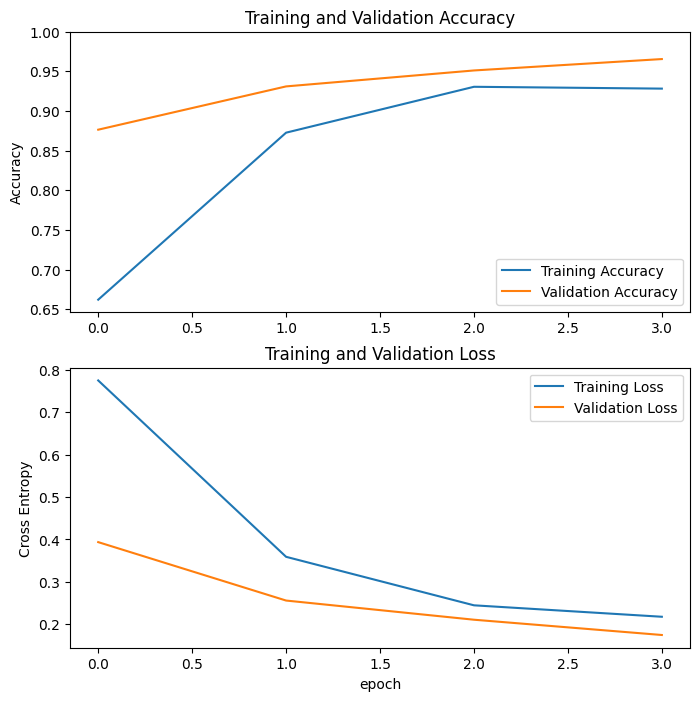

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

epochs = 1
print("Fitting the end-to-end model")
history_fine = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 3)             │      6,147 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,879,923 (79.65 MB)

 Trainable params: 20,813,099 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 12,296 (48.04 KB)

Fitting the end-to-end model


2024-05-20 15:34:01.373142: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:34:01.384932: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:34:01.423312: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:34:01.423368: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-20 15:34:01.716064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/36 ━━━━━━━━━━━━━━━━━━━━ 12:49 22s/step - accuracy: 0.7500 - loss: 0.9432

2024-05-20 15:34:04.575643: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:34:04.719998: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/36 ━━━━━━━━━━━━━━━━━━━━ 1:34 3s/step - accuracy: 0.7326 - loss: 0.8022

2024-05-20 15:34:13.446284: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/36 ━━━━━━━━━━━━━━━━━━━━ 1:27 3s/step - accuracy: 0.7509 - loss: 0.7703

2024-05-20 15:34:19.167993: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:34:19.168043: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: cHRM: inconsistent chromaticities


 9/36 ━━━━━━━━━━━━━━━━━━━━ 1:17 3s/step - accuracy: 0.7538 - loss: 0.7511

2024-05-20 15:34:27.644980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/36 ━━━━━━━━━━━━━━━━━━━━ 1:14 3s/step - accuracy: 0.7518 - loss: 0.7484

2024-05-20 15:34:30.418228: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


13/36 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - accuracy: 0.7486 - loss: 0.7409

2024-05-20 15:34:39.076085: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


19/36 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7569 - loss: 0.7227

2024-05-20 15:34:55.773253: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/36 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.7586 - loss: 0.7201

2024-05-20 15:34:58.691340: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/36 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7597 - loss: 0.7182

2024-05-20 15:35:01.504573: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/36 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7607 - loss: 0.7165

2024-05-20 15:35:04.255183: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/36 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.7613 - loss: 0.7150

2024-05-20 15:35:07.148697: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/36 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.7620 - loss: 0.7133

2024-05-20 15:35:09.960720: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/36 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7628 - loss: 0.7116

2024-05-20 15:35:12.708067: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


27/36 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.7641 - loss: 0.7083

2024-05-20 15:35:18.676983: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7707 - loss: 0.6939

2024-05-20 15:35:44.797844: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:35:45.177331: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:35:45.181103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:35:45.188884: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:35:45.343562: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:35:45.890782: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:35:46.195207: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:35:46.518985: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:35:46.563037: W tensorflow/core/lib/png/png_io.cc:89] PNG 

36/36 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.7714 - loss: 0.6923 - val_accuracy: 0.9713 - val_loss: 0.1641


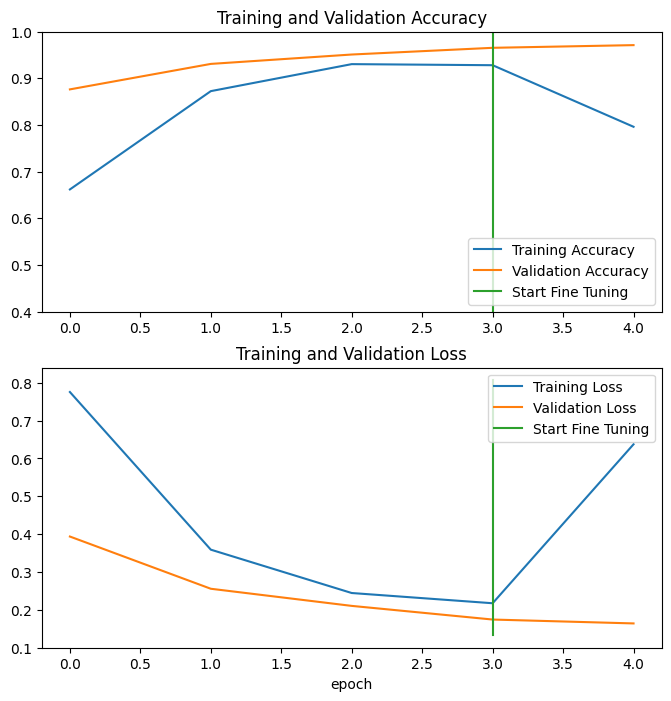

In [17]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1]) 
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation


2024-05-20 15:36:06.195950: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:36:06.217945: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:36:06.349616: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:36:06.756105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:36:06.758392: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:36:06.787402: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-20 15:36:06.851038: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/7 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step - accuracy: 1.0000 - loss: 0.1842

2024-05-20 15:36:08.038319: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 685ms/step - accuracy: 0.9774 - loss: 0.1822


[0.1814773678779602, 0.9642857313156128]

2024-05-20 15:36:16.457522: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


Predictions:
 [0 2 2 1 1 1 0 2 2 2 1 2]
Labels:
 [0 2 2 1 1 1 0 2 2 2 1 2]


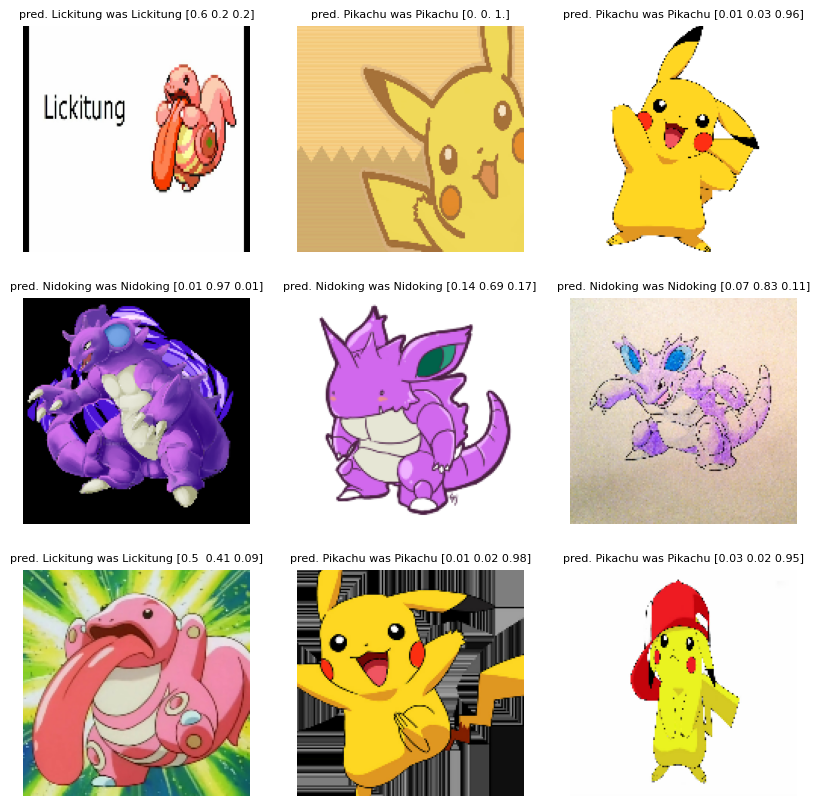

In [19]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions_in_percentage = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions_in_percentage, axis=-1)
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('pred. ' + class_names[predictions[i]] + ' was ' + class_names[label_batch[i]] + ' ' + 	str(np.round(predictions_in_percentage[i], 2)), fontsize=8)
  plt.axis("off")

In [20]:
model.save('Pokemon_pokemon1.keras')

What was the base model you used:
The base model used for the transfer learning project was Xception, pretrained on the ImageNet dataset, utilized via the tensorflow.keras.applications API

What was the performance of the model after transfer-learning, before unfreezing the layers of the base model?
After the initial transfer learning phase and before unfreezing the base model layers, the model achieved a validation accuracy of 97.13%.

What was the performance after fine-tuning?
Following the fine-tuning phase, where additional layers of the base model were unfrozen and the entire model was retrained, the validation accuracy improved to 97.74%.

What Pokémon did you choose?
Lickitung, Nidoking, Pikachu